# CICF Week 12

This notebook builds a neural network model for predicting survival using the Titanic dataset from the previous week.

This notebook borrows from Jeremy Howard's execellent course, [lesson 5](https://github.com/fastai/course22/blob/master/05-linear-model-and-neural-net-from-scratch.ipynb).

In [1]:
import torch, numpy as np, pandas as pd
np.set_printoptions(linewidth=140)
torch.set_printoptions(linewidth=140, sci_mode=False, edgeitems=7)
pd.set_option('display.width', 140)

Before we look at the Titanic dataset, we are first going to look at how PyTorch can caluclate deriatives.
PyTorch is a library extending the NumPy arrays that adds many functions to faciliate working with neural networks. It can also move calculations to a GPU for speed, something that NumPy doesn't do itself.

The fundamental PyTorch datatype is the `tensor`. It is similar to an array of numbers.
Tensors have a _rank_, which is akin to the number of dimensions it has, and a _shape_ which is the number of columns it has in each dimension.

The key thing for tensors is that PyTorch will remember how they are used in a computation so that it can calculate the derivative for each parameter.

In [98]:
def f(x): return x**2

a = torch.tensor(3.)
a.requires_grad_()

tensor(3., requires_grad=True)

In [99]:
yt = f(a)
yt

tensor(9., grad_fn=<PowBackward0>)

In [100]:
yt.backward()
a.grad

tensor(6.)

In [25]:
df = pd.read_csv("../week11/titanic.csv")
df

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


In [3]:
df.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [47]:
modes = df.mode().iloc[0]
df.fillna(modes, inplace=True)

In [48]:
df.describe()

,PassengerId,Survived,Age,SibSp,Parch,Fare,LogFare,Sex_female,Sex_male,Pclass_1,Pclass_2,Pclass_3,Embarked_C,Embarked_Q,Embarked_S
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,28.566970,0.523008,0.381594,32.204208,2.962246,0.352413,0.647587,0.242424,0.206510,0.551066,0.188552,0.086420,0.722783
std,257.353842,0.486592,13.199572,1.102743,0.806057,49.693429,0.969048,0.477990,0.477990,0.428790,0.405028,0.497665,0.391372,0.281141,0.447876
min,1.000000,0.000000,0.420000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,22.000000,0.000000,0.000000,7.910400,2.187218,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,446.000000,0.000000,24.000000,0.000000,0.000000,14.454200,2.737881,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000
75%,668.500000,1.000000,35.000000,1.000000,0.000000,31.000000,3.465736,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000
max,891.000000,1.000000,80.000000,8.000000,6.000000,512.329200,6.240917,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [26]:
df['LogFare'] = np.log(df['Fare']+1)

In [27]:
df = pd.get_dummies(df, columns=["Sex", "Pclass", "Embarked"], dtype=float)
df.columns

Index(['PassengerId', 'Survived', 'Name', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin', 'LogFare', 'Sex_female', 'Sex_male',
       'Pclass_1', 'Pclass_2', 'Pclass_3', 'Embarked_C', 'Embarked_Q', 'Embarked_S'],
      dtype='object')

In [49]:
from torch import tensor
t_dep = tensor(df.Survived)
cols=['Age','SibSp','Parch','LogFare','Sex_male','Sex_female','Pclass_1','Pclass_2','Pclass_3','Embarked_C','Embarked_Q','Embarked_S']
t_indep=tensor(df[cols].values, dtype=float)

In [35]:
t_indep.shape

torch.Size([891, 12])

Normalize each column to only have values between 0 and 1.

In [50]:
vals,_ = t_indep.max(dim=0)
t_indep = t_indep / vals

We are going to make the same model that we used in the spreadsheet: two sets of weights which are multiplied by the independent columns. Then a non-negative function (aka $max(0,x)$ aka ReLU), and then added together.

In [57]:
from torch import nn
torch.manual_seed(442)
model = nn.Sequential(
    nn.Linear(12,2, dtype=float),
    nn.ReLU(),
)
def calc_preds(x):
    y = model(x)
    return y.sum(axis=1)

In [58]:
loss = torch.sum(torch.abs(calc_preds(t_indep)-t_dep))

In [59]:
loss.backward()

In [60]:
optimizer  =torch.optim.SGD(model.parameters(), lr=0.001)

In [61]:
optimizer.step()
optimizer.zero_grad()

In [73]:
from fastai.data.transforms import RandomSplitter
train_split,test_split = RandomSplitter(seed=42)(df)
train_indep, test_indep = t_indep[train_split], t_indep[test_split]
train_dep, test_dep = t_dep[train_split], t_dep[test_split]

In [74]:
def train_model(nloops):
    for i in range(nloops):
        optimizer.zero_grad()
        pred = calc_preds(train_indep)
        loss = torch.mean(torch.abs(pred - train_dep))
        loss.backward()
        optimizer.step()
        print(f"loop: {i}, loss: {loss:>7f}")


In [75]:
train_model(10)

loop: 0, loss: 0.212425
loop: 1, loss: 0.212297
loop: 2, loss: 0.212170
loop: 3, loss: 0.212043
loop: 4, loss: 0.211916
loop: 5, loss: 0.211788
loop: 6, loss: 0.211661
loop: 7, loss: 0.211534
loop: 8, loss: 0.211407
loop: 9, loss: 0.211279


In [76]:
for p in model.parameters(): print(p)

Parameter containing:
tensor([[-0.0836, -0.1562, -0.0925,  0.1516, -0.7237,  0.6614,  0.3275,  0.3220, -0.9256, -0.0205,  0.1028,  0.0375],
        [-0.1980,  0.1385, -0.2328, -0.4433, -0.6048,  0.3697, -0.4307, -0.3428,  0.3637,  0.2890,  0.3146, -0.6060]], dtype=torch.float64,
       requires_grad=True)
Parameter containing:
tensor([0.0325, 0.0223], dtype=torch.float64, requires_grad=True)


In [79]:
with torch.no_grad():
    prediction = calc_preds(test_indep)
    results = test_dep.bool()==(prediction>0.5)
    print(f"Accuracy: {results.float().mean()}")

Accuracy: 0.8258426785469055


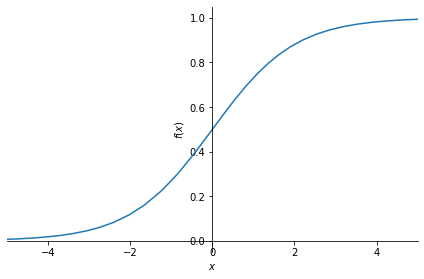

In [90]:
import sympy
sympy.plot("1/(1+exp(-x))", xlim=(-5,5));

In [80]:
def calc_preds(x):
    y = model(x)
    return torch.sigmoid(y.sum(axis=1))

In [85]:
train_model(20)

loop: 0, loss: 0.454624
loop: 1, loss: 0.454620
loop: 2, loss: 0.454617
loop: 3, loss: 0.454613
loop: 4, loss: 0.454610
loop: 5, loss: 0.454606
loop: 6, loss: 0.454602
loop: 7, loss: 0.454599
loop: 8, loss: 0.454595
loop: 9, loss: 0.454592
loop: 10, loss: 0.454588
loop: 11, loss: 0.454585
loop: 12, loss: 0.454581
loop: 13, loss: 0.454578
loop: 14, loss: 0.454574
loop: 15, loss: 0.454570
loop: 16, loss: 0.454567
loop: 17, loss: 0.454563
loop: 18, loss: 0.454560
loop: 19, loss: 0.454556


In [86]:
with torch.no_grad():
    prediction = calc_preds(test_indep)
    results = test_dep.bool()==(prediction>0.5)
    print(f"Accuracy: {results.float().mean()}")

Accuracy: 0.8258426785469055


In [87]:
for p in model.parameters(): print(p)

Parameter containing:
tensor([[-0.0826, -0.1561, -0.0923,  0.1532, -0.7237,  0.6639,  0.3290,  0.3230, -0.9256, -0.0197,  0.1028,  0.0392],
        [-0.1979,  0.1385, -0.2328, -0.4431, -0.6048,  0.3702, -0.4307, -0.3427,  0.3640,  0.2893,  0.3148, -0.6060]], dtype=torch.float64,
       requires_grad=True)
Parameter containing:
tensor([0.0349, 0.0227], dtype=torch.float64, requires_grad=True)


In [89]:
cols

['Age',
 'SibSp',
 'Parch',
 'LogFare',
 'Sex_male',
 'Sex_female',
 'Pclass_1',
 'Pclass_2',
 'Pclass_3',
 'Embarked_C',
 'Embarked_Q',
 'Embarked_S']

Lets try this with a very, _very_ more complicated model.
(It addes weights to the final sum step).

In [179]:
model = nn.Sequential(
    nn.Linear(12,2, dtype=float),
    nn.ReLU(),
    nn.Linear(2,1, dtype=float)
)
def calc_preds(x):
    y = model(x)
    return y
optimizer  =torch.optim.SGD(model.parameters(), lr=0.001)

In [201]:
train_model(200)

loop: 0, loss: 0.379576
loop: 1, loss: 0.379530
loop: 2, loss: 0.379484
loop: 3, loss: 0.379438
loop: 4, loss: 0.379420
loop: 5, loss: 0.379578
loop: 6, loss: 0.379532
loop: 7, loss: 0.379486
loop: 8, loss: 0.379440
loop: 9, loss: 0.379411
loop: 10, loss: 0.379580
loop: 11, loss: 0.379534
loop: 12, loss: 0.379488
loop: 13, loss: 0.379442
loop: 14, loss: 0.379402
loop: 15, loss: 0.379582
loop: 16, loss: 0.379536
loop: 17, loss: 0.379490
loop: 18, loss: 0.379444
loop: 19, loss: 0.379399
loop: 20, loss: 0.379576
loop: 21, loss: 0.379540
loop: 22, loss: 0.379494
loop: 23, loss: 0.379448
loop: 24, loss: 0.379404
loop: 25, loss: 0.379558
loop: 26, loss: 0.379545
loop: 27, loss: 0.379498
loop: 28, loss: 0.379452
loop: 29, loss: 0.379407
loop: 30, loss: 0.379542
loop: 31, loss: 0.379548
loop: 32, loss: 0.379501
loop: 33, loss: 0.379455
loop: 34, loss: 0.379410
loop: 35, loss: 0.379529
loop: 36, loss: 0.379551
loop: 37, loss: 0.379504
loop: 38, loss: 0.379458
loop: 39, loss: 0.379413
loop: 40, 

In [202]:
with torch.no_grad():
    prediction = calc_preds(test_indep)
    results = test_dep.bool()==(prediction>0.5)
    print(f"Accuracy: {results.float().mean()}")

Accuracy: 0.5955055952072144


In [206]:
list(model.parameters())

[Parameter containing:
 tensor([[-0.1960, -0.1220,  0.1653, -0.2724, -0.1901, -0.1111,  0.2767,  0.1198, -0.1633,  0.0999,  0.2361, -0.2181],
         [-0.2748, -0.2190,  0.0676, -0.1815,  0.0796,  0.2002,  0.2100, -0.1078, -0.2290,  0.2101, -0.1251, -0.1723]], dtype=torch.float64,
        requires_grad=True),
 Parameter containing:
 tensor([ 0.1902, -0.0883], dtype=torch.float64, requires_grad=True),
 Parameter containing:
 tensor([[ 0.6278, -0.3675]], dtype=torch.float64, requires_grad=True),
 Parameter containing:
 tensor([0.0003], dtype=torch.float64, requires_grad=True)]